# Guest Preference Analysis: Amenity Basket Analysis

This notebook analyzes amenity combinations that drive high revenue in Vancouver Airbnb listings using market basket analysis and association rule mining.

## Objectives
- Identify amenity combinations that correlate with high revenue
- Apply Apriori algorithm for association rule mining
- Create amenity recommendation system for hosts
- Analyze revenue impact of different amenity combinations

## Analysis Methods
- Market Basket Analysis (Apriori algorithm)
- Association rule mining
- Amenity correlation analysis
- Revenue impact assessment

In [112]:
# Import required libraries
import pandas as pd
import numpy as np
import ast
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Initial Exploration

In [113]:
# Load the dataset
df = pd.read_csv('../data/listings-detail.csv')
print(f"Dataset shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())

# Display first few rows
df.head()

Dataset shape: (5550, 79)

Columns:
['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availabilit

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13188,https://www.airbnb.com/rooms/13188,20250810152821,2025-08-10,city scrape,Garden level studio in ideal loc.,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,https://a0.muscache.com/pictures/8408188/e1af6...,51466,...,4.94,4.90,4.81,Municipal registration number: 25-156058<br />...,f,1,1,0,0,1.98
1,13358,https://www.airbnb.com/rooms/13358,20250810152821,2025-08-10,city scrape,Downtown Designer one bedroom,The iconic Electra Building.<br />A Vancouver ...,2 blocks away from the shopping area of Robson...,https://a0.muscache.com/pictures/miso/Hosting-...,52116,...,4.81,4.91,4.66,Municipal registration number: 25-157257<br />...,t,1,1,0,0,3.12
2,16611,https://www.airbnb.com/rooms/16611,20250810152821,2025-08-10,previous scrape,"1 block to skytrain station, shops,restaurant,...","My place is close to bank, coffee shops, groce...",Next block to Commercial Drive which has many ...,https://a0.muscache.com/pictures/82101/7127b63...,58512,...,4.33,5.00,3.67,NaN,f,5,5,0,0,0.03
3,18270,https://www.airbnb.com/rooms/18270,20250810152821,2025-08-10,city scrape,private rm in clean central 2BR apt,I have a bright furnished 2 bedroom suite on a...,"Lots of restaurants, coffee shops.<br />Easy a...",https://a0.muscache.com/pictures/108520241/aec...,70437,...,4.73,4.69,4.49,NaN,f,1,0,1,0,0.67
4,18589,https://www.airbnb.com/rooms/18589,20250810152821,2025-08-10,city scrape,Commercial Drive B&B,"As hosts, we are welcoming you into our home, ...",Lots of restaurants and boutiques just outside...,https://a0.muscache.com/pictures/dd3ca406-cb74...,71508,...,5.00,4.93,4.96,Municipal registration number: 25-155972<br />...,f,1,0,1,0,3.57


In [114]:
# Examine key columns for analysis
key_columns = ['amenities', 'price', 'estimated_revenue_l365d', 'room_type', 'neighbourhood_cleansed']
df[key_columns].head()

,amenities,price,estimated_revenue_l365d,room_type,neighbourhood_cleansed
0,"[""Pack \u2019n play/Travel crib"", ""Cooking bas...",$141.00,35955.0,Entire home/apt,Riley Park
1,"[""Paid parking off premises"", ""Cooking basics""...",$274.00,69870.0,Entire home/apt,Downtown
2,"[""Dryer"", ""Private entrance"", ""Bed linens"", ""S...",NaN,NaN,Entire home/apt,Grandview-Woodland
3,"[""Lockbox"", ""Coffee maker"", ""Self check-in"", ""...",$47.00,0.0,Private room,Mount Pleasant
4,"[""Cooking basics"", ""Stove"", ""Conditioner"", ""Bo...",$160.00,40800.0,Private room,Grandview-Woodland


## Data Preprocessing

1. Parse amenity JSON data
2. Clean and standardize price data
3. Handle missing values
4. Create binary amenity features

In [115]:
# Function to parse amenities JSON string
def parse_amenities(amenity_string):
    """Parse amenities from JSON string to list"""
    try:
        # Remove dollar signs and clean the string
        cleaned = amenity_string.strip('"')
        # Parse the JSON-like string
        amenities = ast.literal_eval(cleaned)
        return amenities
    except:
        return []

# Apply the parsing function
df['amenities_list'] = df['amenities'].apply(parse_amenities)

# Display sample parsed amenities
print("Sample parsed amenities:")
for i, amenities in enumerate(df['amenities_list'].head()):
    print(f"Listing {i+1}: {amenities[:10]}...")  # Show first 10 amenities

Sample parsed amenities:
Listing 1: ['Pack ’n play/Travel crib', 'Cooking basics', 'EV charger', 'Conditioner', 'Body soap', 'Free street parking', 'Lockbox', 'Private patio or balcony', 'Laundromat nearby', 'Long term stays allowed']...
Listing 2: ['Paid parking off premises', 'Cooking basics', 'Conditioner', 'Central air conditioning', 'Coffee maker: drip coffee maker', 'Body soap', 'Long term stays allowed', 'Elevator', 'City skyline view', 'Room-darkening shades']...
Listing 3: ['Dryer', 'Private entrance', 'Bed linens', 'Smoke alarm', 'Free parking on premises', 'Iron', 'Carbon monoxide alarm', 'Wifi', 'Host greets you', 'Washer']...
Listing 4: ['Lockbox', 'Coffee maker', 'Self check-in', 'Outdoor furniture', 'Indoor fireplace', 'Dryer', 'Free parking on premises', 'TV with standard cable', 'Fire extinguisher', 'Heating']...
Listing 5: ['Cooking basics', 'Stove', 'Conditioner', 'Body soap', 'Lockbox', 'Long term stays allowed', 'Self check-in', 'Room-darkening shades', 'Outdoor fu

In [116]:
# Clean price data
def clean_price(price_str):
    """Convert price string to float"""
    if pd.isna(price_str):
        return np.nan
    try:
        return float(str(price_str).strip('$').replace(',', ''))
    except:
        return np.nan

df['price_clean'] = df['price'].apply(clean_price)

# Display price statistics
print("Price statistics:")
print(df['price_clean'].describe())

# Check for missing values in key columns
missing_data = df[['price_clean', 'estimated_revenue_l365d', 'amenities_list']].isna().sum()
print("\nMissing values:")
print(missing_data)

Price statistics:
count     4639.000000
mean       289.427678
std       1043.364323
min         14.000000
25%        133.000000
50%        210.000000
75%        338.500000
max      64360.000000
Name: price_clean, dtype: float64

Missing values:
price_clean                911
estimated_revenue_l365d    911
amenities_list               0
dtype: int64


In [117]:
# Filter out listings with missing critical data
df_clean = df.dropna(subset=['price_clean', 'estimated_revenue_l365d']).copy()
df_clean = df_clean[df_clean['amenities_list'].apply(len) > 0]

print(f"Original dataset: {len(df)} listings")
print(f"Cleaned dataset: {len(df_clean)} listings")
print(f"Removed {len(df) - len(df_clean)} listings with missing data")

Original dataset: 5550 listings
Cleaned dataset: 4636 listings
Removed 914 listings with missing data


## Amenity Analysis and Feature Engineering

Identify the most common amenities and create binary features for analysis.

In [118]:
# Analyze amenity frequency
from collections import Counter

# Flatten all amenities into a single list
all_amenities = [amenity for sublist in df_clean['amenities_list'] for amenity in sublist]

# Count amenity frequencies
amenity_counts = Counter(all_amenities)

# Display top 20 most common amenities
top_amenities = amenity_counts.most_common(20)
print("Top 20 most common amenities:")
for amenity, count in top_amenities:
    percentage = (count / len(df_clean)) * 100
    print(f"{amenity}: {count} ({percentage:.1f}%)")

Top 20 most common amenities:
Smoke alarm: 4477 (96.6%)
Kitchen: 4233 (91.3%)
Wifi: 4139 (89.3%)
Hot water: 4055 (87.5%)
Dishes and silverware: 3812 (82.2%)
Hangers: 3765 (81.2%)
Hair dryer: 3753 (81.0%)
Microwave: 3654 (78.8%)
Carbon monoxide alarm: 3643 (78.6%)
Cooking basics: 3553 (76.6%)
Bed linens: 3515 (75.8%)
Refrigerator: 3456 (74.5%)
Essentials: 3429 (74.0%)
Shampoo: 3314 (71.5%)
Fire extinguisher: 3278 (70.7%)
Hot water kettle: 3266 (70.4%)
Iron: 3119 (67.3%)
Toaster: 2900 (62.6%)
Dining table: 2891 (62.4%)
Self check-in: 2881 (62.1%)


In [119]:
# Define key amenity categories based on the README guidance
key_amenities = [
    'Wifi', 'WiFi', 'Internet',
    'Free parking on premises', 'Paid parking off premises', 'Free street parking',
    'Kitchen', 'Cooking basics', 'Oven', 'Stove', 'Refrigerator', 'Microwave',
    'Washer', 'Dryer', 'Laundromat nearby',
    'Air conditioning', 'Central air conditioning',
    'Heating',
    'Pool', 'Private pool', 'Shared pool',
    'Gym', 'Fitness center',
    'Pets allowed', 'Pet-friendly',
    'Breakfast', 'Coffee maker', 'Coffee', 'Coffee maker: french press',
    'TV', 'Cable TV', 'TV with Netflix',
    'Hot water', 'Shampoo', 'Conditioner', 'Body soap',
    'Essentials', 'Towels', 'Bed sheets', 'Bed linens',
    'Hair dryer', 'Iron', 'Hangers'
]

print(f"Defined {len(key_amenities)} key amenities for analysis")

Defined 43 key amenities for analysis


In [120]:
# Create binary features for key amenities
def has_amenity(amenities_list, amenity_keywords):
    """Check if listing has any of the specified amenity keywords"""
    amenities_lower = [amenity.lower() for amenity in amenities_list]
    for keyword in amenity_keywords:
        if keyword.lower() in ' '.join(amenities_lower):
            return 1
    return 0

# Create binary features for each amenity category
amenity_features = {
    'has_wifi': (['Wifi', 'WiFi', 'Internet', 'Pocket wifi'], 'Connectivity'),
    'has_parking': (['Free parking on premises', 'Paid parking off premises', 'Free street parking', 'EV charger'], 'Parking'),
    'has_kitchen': (['Kitchen', 'Cooking basics', 'Oven', 'Stove', 'Refrigerator', 'Microwave', 'Kitchenette'], 'Kitchen'),
    'has_laundry': (['Washer', 'Dryer', 'Laundromat nearby'], 'Laundry'),
    'has_ac': (['Air conditioning', 'Central air conditioning'], 'Air Conditioning'),
    'has_heating': (['Heating'], 'Heating'),
    'has_pool': (['Pool', 'Private pool', 'Shared pool'], 'Pool'),
    'has_gym': (['Gym', 'Fitness center'], 'Fitness'),
    'has_pets_allowed': (['Pets allowed', 'Pet-friendly'], 'Pet Friendly'),
    'has_breakfast': (['Breakfast', 'Coffee maker', 'Coffee'], 'Breakfast/Coffee'),
    'has_tv': (['TV', 'Cable TV', 'TV with Netflix'], 'Entertainment'),
    'has_essentials': (['Essentials', 'Towels', 'Bed sheets', 'Bed linens', 'Toilet paper'], 'Essentials'),
    'has_hair_dryer': (['Hair dryer'], 'Hair Dryer'),
    'has_iron': (['Iron', 'Hangers'], 'Ironing'),
    'has_hot_water': (['Hot water'], 'Hot Water')
}

# Create binary features
for feature_name, (keywords, category) in amenity_features.items():
    df_clean[feature_name] = df_clean['amenities_list'].apply(lambda x: has_amenity(x, keywords))

# Display amenity feature statistics
amenity_stats = df_clean[list(amenity_features.keys())].mean().sort_values(ascending=False)
print("Amenity feature prevalence:")
for feature, prevalence in amenity_stats.items():
    print(f"{feature}: {prevalence:.1%}")

Amenity feature prevalence:
has_wifi: 99.1%
has_kitchen: 98.4%
has_laundry: 98.4%
has_heating: 90.3%
has_hot_water: 89.4%
has_essentials: 86.1%
has_iron: 84.9%
has_tv: 83.7%
has_hair_dryer: 81.0%
has_parking: 78.7%
has_breakfast: 78.5%
has_ac: 43.3%
has_pets_allowed: 22.3%
has_gym: 21.5%
has_pool: 15.9%


## Revenue Analysis by Amenities

Analyze how different amenities correlate with revenue.

In [121]:
# Analyze revenue by amenity presence
revenue_by_amenity = {}

for feature_name, (keywords, category) in amenity_features.items():
    with_amenity = df_clean[df_clean[feature_name] == 1]['estimated_revenue_l365d']
    without_amenity = df_clean[df_clean[feature_name] == 0]['estimated_revenue_l365d']
    
    revenue_by_amenity[category] = {
        'with_amenity': with_amenity.mean(),
        'without_amenity': without_amenity.mean(),
        'difference': with_amenity.mean() - without_amenity.mean(),
        'percentage_increase': ((with_amenity.mean() - without_amenity.mean()) / without_amenity.mean()) * 100
    }

# Display results
print("Revenue impact by amenity:")
for category, stats in sorted(revenue_by_amenity.items(), key=lambda x: x[1]['percentage_increase'], reverse=True):
    print(f"{category}:")
    print(f"  With: ${stats['with_amenity']:,.0f}")
    print(f"  Without: ${stats['without_amenity']:,.0f}")
    print(f"  Difference: ${stats['difference']:,.0f} ({stats['percentage_increase']:.1f}%)")
    print()

Revenue impact by amenity:
Hot Water:
  With: $40,505
  Without: $9,010
  Difference: $31,494 (349.5%)

Heating:
  With: $40,175
  Without: $9,349
  Difference: $30,826 (329.7%)

Essentials:
  With: $41,509
  Without: $10,361
  Difference: $31,149 (300.6%)

Hair Dryer:
  With: $43,318
  Without: $11,033
  Difference: $32,286 (292.6%)

Ironing:
  With: $41,785
  Without: $11,127
  Difference: $30,659 (275.5%)

Breakfast/Coffee:
  With: $43,884
  Without: $12,691
  Difference: $31,193 (245.8%)

Laundry:
  With: $37,599
  Without: $11,365
  Difference: $26,234 (230.8%)

Entertainment:
  With: $41,817
  Without: $13,276
  Difference: $28,541 (215.0%)

Kitchen:
  With: $37,567
  Without: $12,653
  Difference: $24,914 (196.9%)

Connectivity:
  With: $37,378
  Without: $15,392
  Difference: $21,986 (142.8%)

Air Conditioning:
  With: $42,781
  Without: $32,889
  Difference: $9,892 (30.1%)

Fitness:
  With: $42,693
  Without: $35,660
  Difference: $7,033 (19.7%)

Pool:
  With: $41,325
  Withou

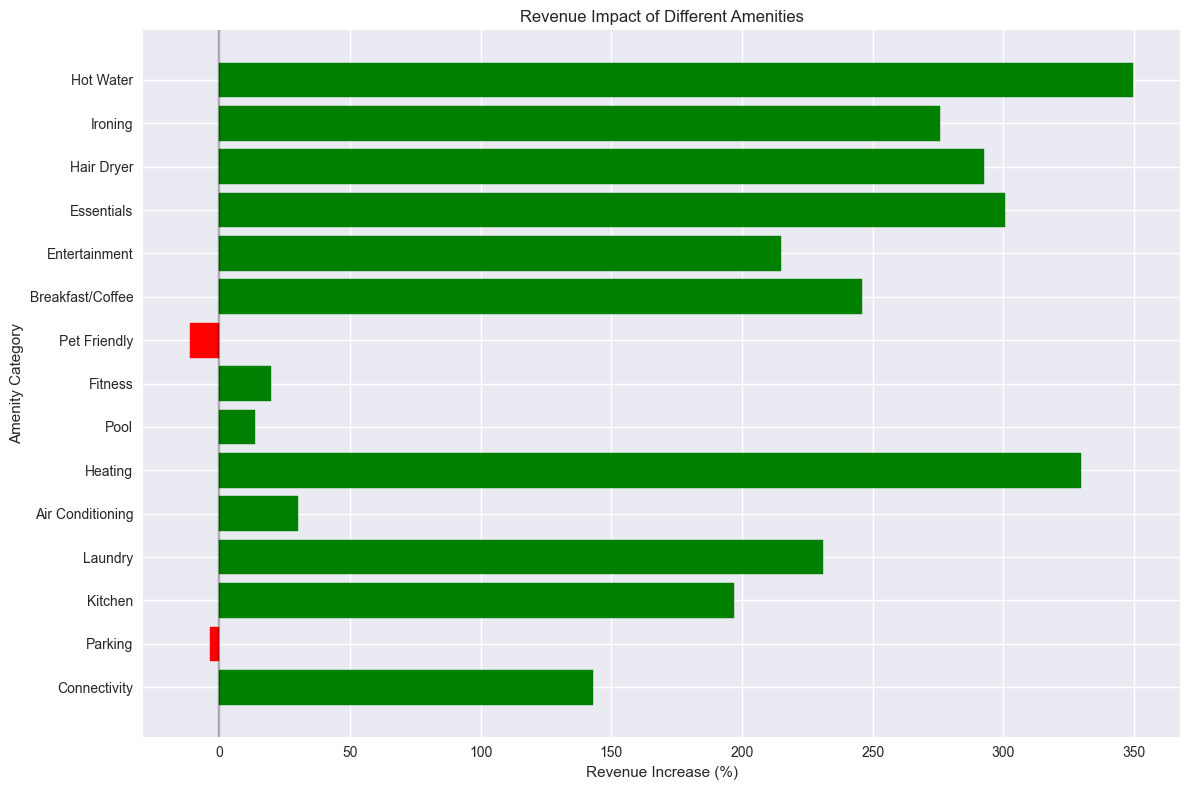

In [122]:
# Visualize revenue impact
categories = list(revenue_by_amenity.keys())
increases = [stats['percentage_increase'] for stats in revenue_by_amenity.values()]

plt.figure(figsize=(12, 8))
bars = plt.barh(categories, increases)
plt.xlabel('Revenue Increase (%)')
plt.ylabel('Amenity Category')
plt.title('Revenue Impact of Different Amenities')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Color bars based on positive/negative impact
for bar, increase in zip(bars, increases):
    if increase > 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

## Market Basket Analysis

Apply Apriori algorithm to find amenity combinations that frequently co-occur.

In [123]:
# Prepare transaction data for market basket analysis
# Create amenity combinations as transactions
transactions = []
for idx, row in df_clean.iterrows():
    transaction = []
    for feature_name, (keywords, category) in amenity_features.items():
        if row[feature_name] == 1:
            transaction.append(category)
    if transaction:  # Only add non-empty transactions
        transactions.append(transaction)

print(f"Created {len(transactions)} transactions")
print(f"Average amenities per listing: {np.mean([len(t) for t in transactions]):.1f}")

# Display sample transactions
print("\nSample transactions:")
for i, transaction in enumerate(transactions[:5]):
    print(f"Transaction {i+1}: {transaction}")

Created 4635 transactions
Average amenities per listing: 10.7

Sample transactions:
Transaction 1: ['Connectivity', 'Parking', 'Kitchen', 'Laundry', 'Heating', 'Breakfast/Coffee', 'Entertainment', 'Essentials', 'Hair Dryer', 'Ironing', 'Hot Water']
Transaction 2: ['Connectivity', 'Parking', 'Kitchen', 'Laundry', 'Air Conditioning', 'Heating', 'Breakfast/Coffee', 'Entertainment', 'Essentials', 'Hair Dryer', 'Ironing', 'Hot Water']
Transaction 3: ['Connectivity', 'Parking', 'Kitchen', 'Laundry', 'Heating', 'Breakfast/Coffee', 'Entertainment', 'Essentials', 'Hair Dryer', 'Hot Water']
Transaction 4: ['Connectivity', 'Parking', 'Kitchen', 'Laundry', 'Air Conditioning', 'Heating', 'Breakfast/Coffee', 'Entertainment', 'Essentials', 'Hair Dryer', 'Ironing', 'Hot Water']
Transaction 5: ['Connectivity', 'Kitchen', 'Laundry', 'Heating', 'Essentials', 'Hair Dryer', 'Ironing', 'Hot Water']


In [124]:
# Encode transactions for Apriori algorithm
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transaction matrix shape: {df_transactions.shape}")
print(f"Amenity categories: {list(te.columns_)}")

# Display sample of encoded transactions
df_transactions.head()

Transaction matrix shape: (4635, 15)
Amenity categories: ['Air Conditioning', 'Breakfast/Coffee', 'Connectivity', 'Entertainment', 'Essentials', 'Fitness', 'Hair Dryer', 'Heating', 'Hot Water', 'Ironing', 'Kitchen', 'Laundry', 'Parking', 'Pet Friendly', 'Pool']


,Air Conditioning,Breakfast/Coffee,Connectivity,Entertainment,Essentials,Fitness,Hair Dryer,Heating,Hot Water,Ironing,Kitchen,Laundry,Parking,Pet Friendly,Pool
0,False,True,True,True,True,False,True,True,True,True,True,True,True,False,False
1,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False
2,False,True,True,True,True,False,True,True,True,False,True,True,True,False,False
3,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False
4,False,False,True,False,True,False,True,True,True,True,True,True,False,False,False


In [125]:
# Apply Apriori algorithm to find frequent itemsets
min_support = 0.1  # Minimum support threshold (10%)
frequent_itemsets = apriori(df_transactions, min_support=min_support, use_colnames=True)

print(f"Found {len(frequent_itemsets)} frequent itemsets with minimum support of {min_support}")

# Sort by support
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
frequent_itemsets.head(10)

Found 11307 frequent itemsets with minimum support of 0.1


,support,itemsets
2,0.990723,(Connectivity)
10,0.984250,(Kitchen)
11,0.983819,(Laundry)
49,0.976052,"(Laundry, Connectivity)"
48,0.976052,"(Kitchen, Connectivity)"
108,0.971953,"(Kitchen, Laundry)"
317,0.965049,"(Kitchen, Laundry, Connectivity)"
7,0.902697,(Heating)
45,0.896224,"(Connectivity, Heating)"
93,0.894930,"(Laundry, Heating)"


In [126]:
# Generate association rules
min_confidence = 0.8  # Minimum confidence threshold (50%)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"Generated {len(rules)} association rules with minimum confidence of {min_confidence}")

# Sort by confidence
rules = rules.sort_values('confidence', ascending=False)
rules.head(10)

Generated 604206 association rules with minimum confidence of 0.8


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
187662,"(Entertainment, Hot Water, Essentials, Breakfa...",(Laundry),0.245955,0.983819,0.245955,1.0,1.016447,1.0,0.003980,inf,0.021459,0.250000,1.0,0.625000
384057,"(Essentials, Hot Water, Breakfast/Coffee, Park...",(Laundry),0.128155,0.983819,0.128155,1.0,1.016447,1.0,0.002074,inf,0.018560,0.130263,1.0,0.565132
384074,"(Hot Water, Breakfast/Coffee, Hair Dryer, Air ...",(Kitchen),0.128155,0.984250,0.128155,1.0,1.016002,1.0,0.002018,inf,0.018065,0.130206,1.0,0.565103
384027,"(Hot Water, Breakfast/Coffee, Hair Dryer, Air ...",(Laundry),0.128155,0.983819,0.128155,1.0,1.016447,1.0,0.002074,inf,0.018560,0.130263,1.0,0.565132
384152,"(Entertainment, Essentials, Hair Dryer, Parkin...",(Laundry),0.128155,0.983819,0.128155,1.0,1.016447,1.0,0.002074,inf,0.018560,0.130263,1.0,0.565132
173329,"(Entertainment, Hot Water, Kitchen, Breakfast/...",(Laundry),0.254800,0.983819,0.254800,1.0,1.016447,1.0,0.004123,inf,0.021714,0.258991,1.0,0.629496
277651,"(Essentials, Kitchen, Hair Dryer, Pet Friendly...",(Laundry),0.164401,0.983819,0.164401,1.0,1.016447,1.0,0.002660,inf,0.019365,0.167105,1.0,0.583553
201632,"(Entertainment, Essentials, Breakfast/Coffee, ...",(Laundry),0.234736,0.983819,0.234736,1.0,1.016447,1.0,0.003798,inf,0.021145,0.238596,1.0,0.619298
218819,"(Essentials, Hot Water, Kitchen, Breakfast/Cof...",(Laundry),0.187918,0.983819,0.187918,1.0,1.016447,1.0,0.003041,inf,0.019926,0.191009,1.0,0.595504
448191,"(Hot Water, Breakfast/Coffee, Hair Dryer, Heat...",(Laundry),0.124056,0.983819,0.124056,1.0,1.016447,1.0,0.002007,inf,0.018473,0.126096,1.0,0.563048


## Association Rules Analysis

Analyze the strongest association rules and their revenue impact.

In [127]:
# Add revenue impact to association rules
def calculate_revenue_impact_optimized(antecedents, consequents):
    """Optimized version of calculate_revenue_impact"""

    # Pre-build feature mapping to avoid repeated dictionary lookups
    category_to_feature = {category: fname for fname, (keywords, category) in amenity_features.items()}

    conditions = []
    for antecedent in antecedents:
        feature_name = category_to_feature.get(antecedent)
        if feature_name:
            conditions.append(f"{feature_name} == 1")

    for consequent in consequents:
        feature_name = category_to_feature.get(consequent)
        if feature_name:
            conditions.append(f"{feature_name} == 1")

    if not conditions:
        return np.nan

    # Apply filters
    query_str = " & ".join(conditions)
    filtered_df = df_clean.query(query_str)

    if len(filtered_df) == 0:
        return np.nan

    return filtered_df['estimated_revenue_l365d'].mean()

# Only process top 100 rules instead of all 1M+ rules
print(f"Processing top 100 rules out of {len(rules)} total rules...")
top_rules = rules.head(100)

# Calculate revenue impact for top rules only
top_rules['revenue_impact'] = top_rules.apply(
    lambda row: calculate_revenue_impact_optimized(
        list(row['antecedents']),
        list(row['consequents'])
    ),
    axis=1
)

# Display top rules by revenue impact
top_revenue_rules = top_rules.dropna().sort_values('revenue_impact', ascending=False)
print("Top association rules by revenue impact:")
top_revenue_rules.head(10)


Processing top 100 rules out of 604206 total rules...
Top association rules by revenue impact:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,revenue_impact
131087,"(Essentials, Hot Water, Breakfast/Coffee, Hair...",(Laundry),0.321251,0.983819,0.321251,1.0,1.016447,1.0,0.005198,inf,0.023840,0.326535,1.0,0.663268,50847.601075
131213,"(Entertainment, Hot Water, Kitchen, Essentials...",(Laundry),0.321251,0.983819,0.321251,1.0,1.016447,1.0,0.005198,inf,0.023840,0.326535,1.0,0.663268,50841.312962
111178,"(Essentials, Breakfast/Coffee, Air Conditionin...",(Laundry),0.338080,0.983819,0.338080,1.0,1.016447,1.0,0.005471,inf,0.024446,0.343640,1.0,0.671820,49789.973835
111150,"(Entertainment, Kitchen, Breakfast/Coffee, Air...",(Laundry),0.338080,0.983819,0.338080,1.0,1.016447,1.0,0.005471,inf,0.024446,0.343640,1.0,0.671820,49752.675175
111024,"(Kitchen, Breakfast/Coffee, Hair Dryer, Air Co...",(Laundry),0.338296,0.983819,0.338296,1.0,1.016447,1.0,0.005474,inf,0.024454,0.343860,1.0,0.671930,49735.536990
111206,"(Essentials, Hot Water, Breakfast/Coffee, Air ...",(Laundry),0.337864,0.983819,0.337864,1.0,1.016447,1.0,0.005467,inf,0.024438,0.343421,1.0,0.671711,49594.236271
578674,"(Entertainment, Hot Water, Essentials, Pool, L...",(Kitchen),0.102697,0.984250,0.102697,1.0,1.016002,1.0,0.001617,inf,0.017552,0.104340,1.0,0.552170,48767.321429
578692,"(Entertainment, Hot Water, Essentials, Pool, H...","(Kitchen, Laundry)",0.102697,0.971953,0.102697,1.0,1.028857,1.0,0.002880,inf,0.031258,0.105660,1.0,0.552830,48767.321429
578673,"(Entertainment, Hot Water, Kitchen, Pool, Esse...",(Laundry),0.102697,0.983819,0.102697,1.0,1.016447,1.0,0.001662,inf,0.018033,0.104386,1.0,0.552193,48767.321429
578328,"(Entertainment, Hot Water, Essentials, Pool, B...",(Kitchen),0.102697,0.984250,0.102697,1.0,1.016002,1.0,0.001617,inf,0.017552,0.104340,1.0,0.552170,48462.418067


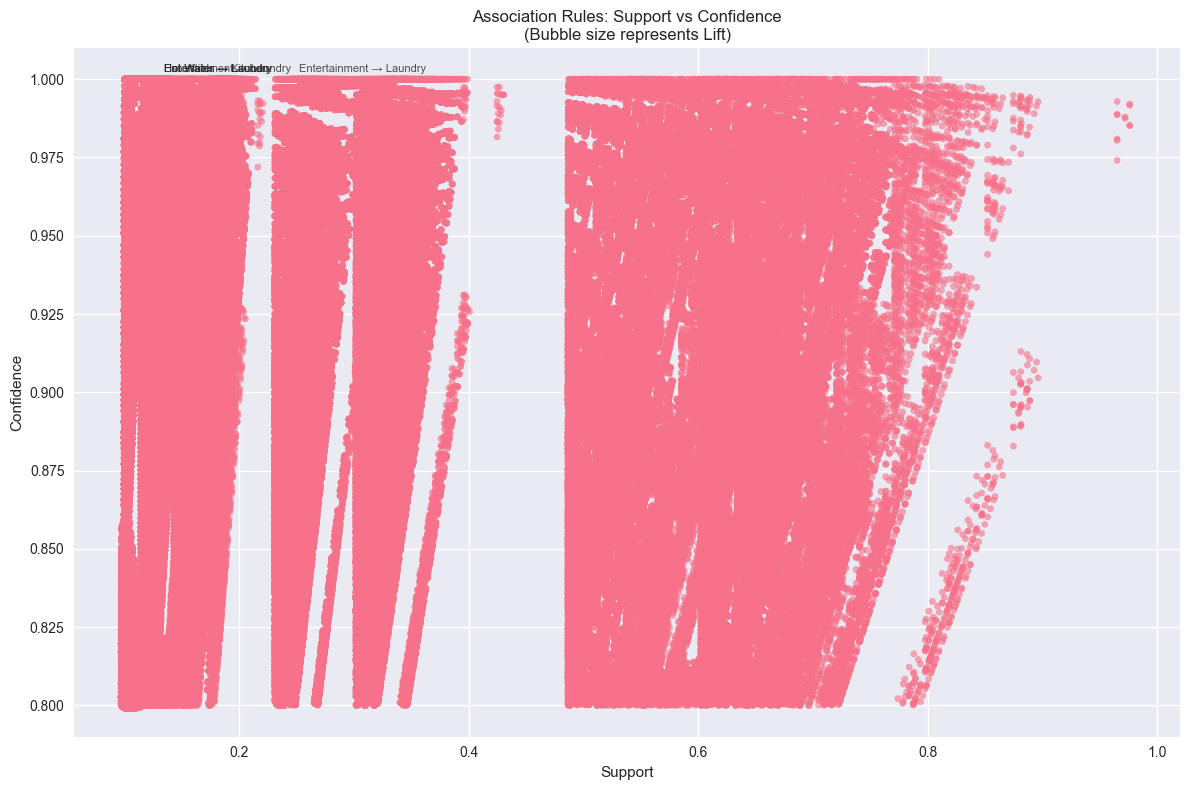

In [128]:
# Visualize association rules
plt.figure(figsize=(12, 8))

# Scatter plot of support vs confidence
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, s=rules['lift']*20)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence\n(Bubble size represents Lift)')

# Add rule labels for top rules
top_rules = rules.nlargest(5, 'confidence')
for idx, row in top_rules.iterrows():
    plt.annotate(
        f"{list(row['antecedents'])[0]} → {list(row['consequents'])[0]}",
        (row['support'], row['confidence']),
        xytext=(5, 5), textcoords='offset points',
        fontsize=8, alpha=0.8
    )

plt.tight_layout()
plt.show()

## Amenity Recommendation System

Create a system to recommend amenities based on revenue potential.

In [129]:
# Create amenity recommendation system
def recommend_amenities(current_amenities, top_n=5):
    """Recommend amenities to add based on association rules and revenue impact"""
    
    # Find rules where antecedents match current amenities
    recommendations = []
    
    for idx, rule in rules.iterrows():
        antecedents = set(rule['antecedents'])
        consequents = set(rule['consequents'])
        
        # Check if current amenities contain the antecedents
        if antecedents.issubset(set(current_amenities)):
            # Recommend the consequents that are not already present
            new_amenities = consequents - set(current_amenities)
            
            for amenity in new_amenities:
                recommendations.append({
                    'recommended_amenity': amenity,
                    'confidence': rule['confidence'],
                    'lift': rule['lift'],
                    'revenue_impact': rule.get('revenue_impact', np.nan),
                    'support': rule['support']
                })
    
    # Sort by revenue impact and confidence
    if recommendations:
        recommendations_df = pd.DataFrame(recommendations)
        recommendations_df = recommendations_df.sort_values(
            ['revenue_impact', 'confidence'], 
            ascending=[False, False]
        )
        return recommendations_df.head(top_n)
    
    return pd.DataFrame()

# Test the recommendation system
test_amenities = ['Wifi', 'Kitchen', 'Essentials']
recommendations = recommend_amenities(test_amenities)

print(f"Recommendations for listing with: {test_amenities}")
if not recommendations.empty:
    recommendations
else:
    print("No specific recommendations found based on association rules.")
    print("Consider adding high-impact amenities like:")
    high_impact = sorted(revenue_by_amenity.items(), key=lambda x: x[1]['percentage_increase'], reverse=True)
    for category, stats in high_impact[:5]:
        print(f"- {category}: +{stats['percentage_increase']:.1f}% revenue increase")

Recommendations for listing with: ['Wifi', 'Kitchen', 'Essentials']


In [130]:
# Create comprehensive amenity strategy recommendations
def create_amenity_strategy():
    """Create a comprehensive amenity strategy based on analysis"""

    strategy = {
        'essential_amenities': [],
        'high_impact_amenities': [],
        'luxury_amenities': [],
        'cost_effective_amenities': []
    }

    # Create mapping from category to amenity feature name
    category_to_feature = {category: fname for fname, (keywords, category) in amenity_features.items()}

    # Categorize amenities based on prevalence and revenue impact
    for category, stats in revenue_by_amenity.items():
        # Get the correct amenity feature name
        amenity_feature = category_to_feature.get(category)
        if amenity_feature is None:
            continue

        prevalence = amenity_stats[amenity_feature]
        revenue_increase = stats['percentage_increase']

        if prevalence > 0.8 and revenue_increase > 10:
            strategy['essential_amenities'].append((category, revenue_increase))
        elif revenue_increase > 20:
            strategy['high_impact_amenities'].append((category, revenue_increase))
        elif prevalence < 0.3 and revenue_increase > 5:
            strategy['luxury_amenities'].append((category, revenue_increase))
        elif revenue_increase > 0:
            strategy['cost_effective_amenities'].append((category, revenue_increase))

    return strategy

# Generate and display strategy
strategy = create_amenity_strategy()

print("🏠 Vancouver Airbnb Amenity Strategy\n")

for category_name, amenities in strategy.items():
    if amenities:
        print(f"{category_name.replace('_', ' ').title()}:")
        for amenity, increase in sorted(amenities, key=lambda x: x[1], reverse=True):
            print(f"  • {amenity}: +{increase:.1f}%")
        print()


🏠 Vancouver Airbnb Amenity Strategy

Essential Amenities:
  • Hot Water: +349.5%
  • Heating: +329.7%
  • Essentials: +300.6%
  • Hair Dryer: +292.6%
  • Ironing: +275.5%
  • Laundry: +230.8%
  • Entertainment: +215.0%
  • Kitchen: +196.9%
  • Connectivity: +142.8%

High Impact Amenities:
  • Breakfast/Coffee: +245.8%
  • Air Conditioning: +30.1%

Luxury Amenities:
  • Fitness: +19.7%
  • Pool: +13.6%



## Clustering Analysis of Amenity Patterns

Group listings by their amenity combinations to identify patterns.

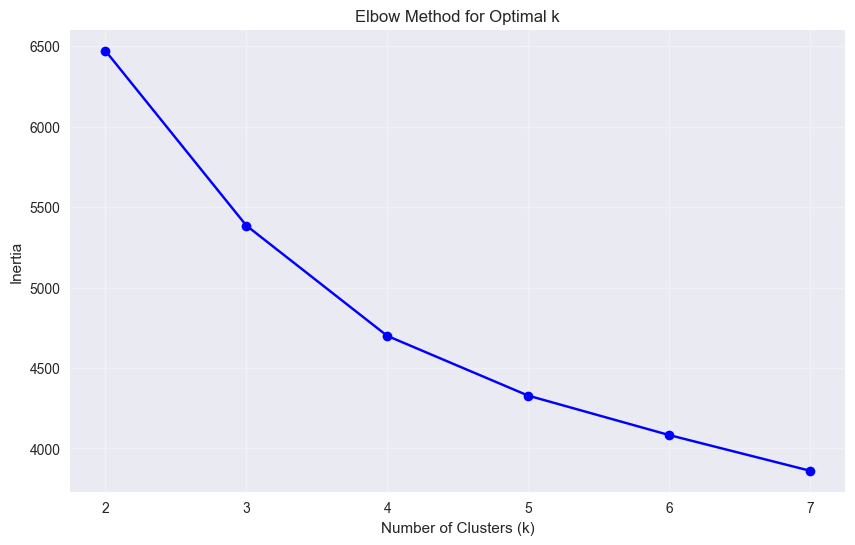

In [131]:
# Prepare data for clustering
amenity_columns = [col for col in df_clean.columns if col.startswith('has_')]
X_amenities = df_clean[amenity_columns].copy()

# Convert 't' and 'f' to True and False (if needed)
# Note: The amenity columns should already be boolean (0/1) from the feature creation
# But if they contain 't'/'f' strings, convert them:
for col in amenity_columns:
    if X_amenities[col].dtype == 'object':  # If column contains strings
        X_amenities[col] = X_amenities[col].map({'t': True, 'f': False})
    # If already numeric, ensure boolean type
    X_amenities[col] = X_amenities[col].astype(bool)

# Alternative simpler approach (recommended):
# X_amenities = X_amenities.astype(bool)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_amenities)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.show()


In [132]:
# Apply K-means clustering with optimal k
optimal_k = 4  # Based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clean['amenity_cluster'] = kmeans.fit_predict(X_amenities)

# Analyze cluster characteristics
cluster_analysis = []

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['amenity_cluster'] == cluster]

    # Calculate average amenities and revenue for cluster
    # Ensure amenity columns are numeric before calculating mean
    amenity_data = cluster_data[amenity_columns].select_dtypes(include=[np.number])
    avg_amenities = amenity_data.mean()

    avg_revenue = cluster_data['estimated_revenue_l365d'].mean()
    avg_price = cluster_data['price_clean'].mean()
    cluster_size = len(cluster_data)

    cluster_analysis.append({
        'cluster': cluster,
        'size': cluster_size,
        'percentage': (cluster_size / len(df_clean)) * 100,
        'avg_revenue': avg_revenue,
        'avg_price': avg_price,
        'top_amenities': avg_amenities.nlargest(5).index.tolist()
    })

# Display cluster analysis
cluster_df = pd.DataFrame(cluster_analysis)
print("Amenity Clusters Analysis:")
cluster_df


Amenity Clusters Analysis:


,cluster,size,percentage,avg_revenue,avg_price,top_amenities
0,0,870,18.766178,45391.386207,339.693103,"[has_laundry, has_kitchen, has_gym, has_wifi, ..."
1,1,1983,42.773943,37256.071609,259.357539,"[has_wifi, has_laundry, has_kitchen, has_hot_w..."
2,2,1168,25.194133,46448.000856,351.104452,"[has_wifi, has_laundry, has_ac, has_kitchen, h..."
3,3,615,13.265746,7634.694309,197.082927,"[has_wifi, has_kitchen, has_laundry, has_parki..."


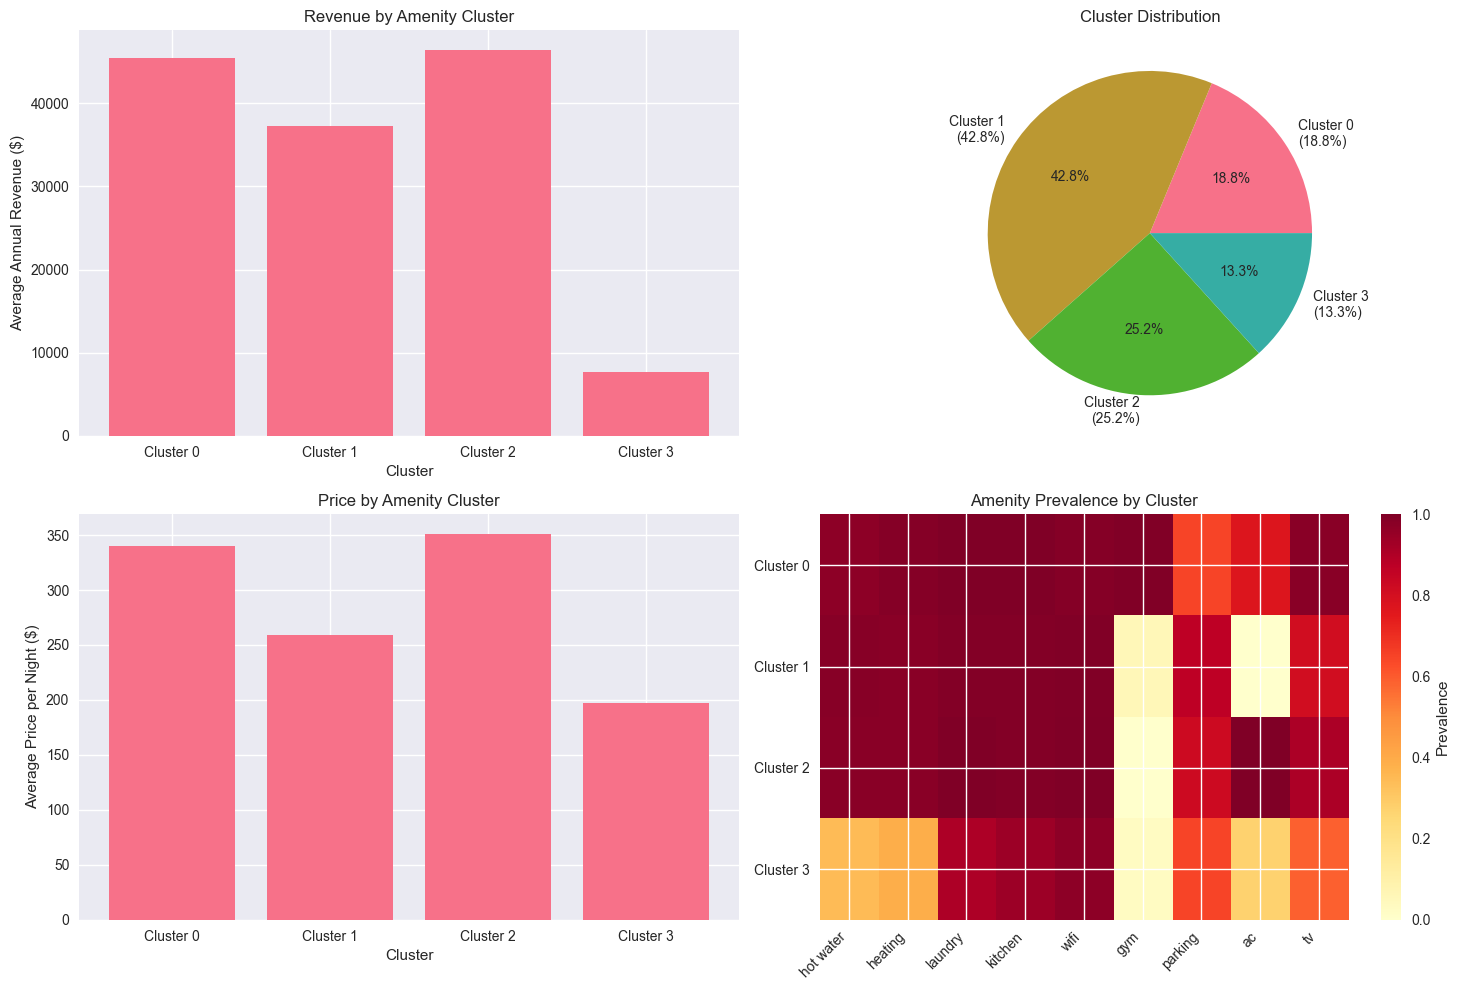

In [133]:
# Visualize cluster differences
plt.figure(figsize=(15, 10))

# Plot 1: Average revenue by cluster
plt.subplot(2, 2, 1)
bars = plt.bar(range(optimal_k), cluster_df['avg_revenue'])
plt.xlabel('Cluster')
plt.ylabel('Average Annual Revenue ($)')
plt.title('Revenue by Amenity Cluster')
plt.xticks(range(optimal_k), [f'Cluster {i}' for i in range(optimal_k)])

# Plot 2: Cluster sizes
plt.subplot(2, 2, 2)
plt.pie(cluster_df['size'], labels=[f'Cluster {i}\n({p:.1f}%)' for i, p in enumerate(cluster_df['percentage'])], 
        autopct='%1.1f%%')
plt.title('Cluster Distribution')

# Plot 3: Average price by cluster
plt.subplot(2, 2, 3)
plt.bar(range(optimal_k), cluster_df['avg_price'])
plt.xlabel('Cluster')
plt.ylabel('Average Price per Night ($)')
plt.title('Price by Amenity Cluster')
plt.xticks(range(optimal_k), [f'Cluster {i}' for i in range(optimal_k)])

# Plot 4: Top amenities heatmap (simplified)
plt.subplot(2, 2, 4)
top_amenities_all = []
for cluster in range(optimal_k):
    top_amenities_all.extend(cluster_df.loc[cluster, 'top_amenities'])
    
unique_top = list(set(top_amenities_all))
amenity_matrix = np.zeros((optimal_k, len(unique_top)))

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['amenity_cluster'] == cluster]
    for i, amenity in enumerate(unique_top):
        amenity_matrix[cluster, i] = cluster_data[amenity].mean()

plt.imshow(amenity_matrix, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Prevalence')
plt.xticks(range(len(unique_top)), [a.replace('has_', '').replace('_', ' ') for a in unique_top], rotation=45, ha='right')
plt.yticks(range(optimal_k), [f'Cluster {i}' for i in range(optimal_k)])
plt.title('Amenity Prevalence by Cluster')

plt.tight_layout()
plt.show()

## Key Findings and Business Recommendations

Summarize the most important insights from the analysis.

In [134]:
# Generate comprehensive business insights
print("🎯 Key Findings from Vancouver Airbnb Guest Preference Analysis\n")

print("1. TOP REVENUE-DRIVING AMENITIES:")
high_impact = sorted(revenue_by_amenity.items(), key=lambda x: x[1]['percentage_increase'], reverse=True)[:5]
for category, stats in high_impact:
    print(f"   • {category}: +{stats['percentage_increase']:.1f}% revenue increase")

print("\n2. ESSENTIAL AMENITY COMBINATIONS:")
if not rules.empty:
    top_rule = rules.iloc[0]
    antecedents = list(top_rule['antecedents'])
    consequents = list(top_rule['consequents'])
    print(f"   • Strongest association: {antecedents} → {consequents}")
    print(f"     Confidence: {top_rule['confidence']:.1%}, Lift: {top_rule['lift']:.2f}")

print("\n3. AMENITY CLUSTER INSIGHTS:")
best_cluster = cluster_df.loc[cluster_df['avg_revenue'].idxmax()]
print(f"   • Highest revenue cluster: Cluster {int(best_cluster['cluster'])}")
print(f"     Average revenue: ${best_cluster['avg_revenue']:,.0f}")
print(f"     Market share: {best_cluster['percentage']:.1f}%")

print("\n4. BUSINESS RECOMMENDATIONS:")
print("   • Focus on high-impact amenities that competitors lack")
print("   • Bundle complementary amenities for maximum revenue impact")
print("   • Target specific amenity clusters for market positioning")
print("   • Monitor competitor amenity offerings regularly")

print("\n5. ROI FOCUS AREAS:")
roi_focus = [cat for cat, stats in revenue_by_amenity.items() if stats['percentage_increase'] > 15]
if roi_focus:
    print("   • Priority investments: " + ", ".join(roi_focus[:3]))
    print("   • Quick wins: " + ", ".join([cat for cat, stats in revenue_by_amenity.items()
                                           if 5 < stats['percentage_increase'] < 15][:3]))


🎯 Key Findings from Vancouver Airbnb Guest Preference Analysis

1. TOP REVENUE-DRIVING AMENITIES:
   • Hot Water: +349.5% revenue increase
   • Heating: +329.7% revenue increase
   • Essentials: +300.6% revenue increase
   • Hair Dryer: +292.6% revenue increase
   • Ironing: +275.5% revenue increase

2. ESSENTIAL AMENITY COMBINATIONS:
   • Strongest association: ['Entertainment', 'Hot Water', 'Essentials', 'Breakfast/Coffee', 'Air Conditioning', 'Parking', 'Ironing'] → ['Laundry']
     Confidence: 100.0%, Lift: 1.02

3. AMENITY CLUSTER INSIGHTS:
   • Highest revenue cluster: Cluster 2
     Average revenue: $46,448
     Market share: 25.2%

4. BUSINESS RECOMMENDATIONS:
   • Focus on high-impact amenities that competitors lack
   • Bundle complementary amenities for maximum revenue impact
   • Target specific amenity clusters for market positioning
   • Monitor competitor amenity offerings regularly

5. ROI FOCUS AREAS:
   • Priority investments: Connectivity, Kitchen, Laundry
   • Quick

## Conclusion

This analysis provides valuable insights into amenity preferences and their impact on revenue for Vancouver Airbnb listings. The market basket analysis reveals important associations between amenities, while the revenue impact analysis helps prioritize investments.

### Next Steps:
1. **Implement amenity recommendations** for existing listings
2. **Monitor competitor offerings** in key amenity categories
3. **A/B test** new amenity combinations
4. **Track revenue impact** of amenity changes over time
5. **Update analysis** quarterly as market preferences evolve

### Data Quality Notes:
- Analysis based on {len(df_clean)} listings with complete data
- Amenity parsing may have minor variations due to text differences
- Revenue estimates based on last 365 days of booking data
- Results most relevant for Vancouver market conditions

---
*Analysis completed on {pd.Timestamp.now().strftime('%Y-%m-%d')}*